In [1]:
import os
import pandas as pd
import numpy as np
import torch

In [2]:
# https://chriskhanhtran.github.io/posts/cnn-sentence-classification/

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
Device name: NVIDIA GeForce GTX 1070


In [4]:
def record_data_info(class_nm, txt_cnt):
    with open('../data/info.txt', 'a') as f:
        f.write(class_nm + ': ' + str(txt_cnt) + '\n')

In [5]:
def record_nonAscii_txt(fn):
    with open('../data/nonAsciiTxt.txt', 'a') as f:
        f.write(fn + '\n')

In [6]:
def print_nonAscii_info(nonAsciiDict):
    with open('../data/nonAsciiInfo.txt', 'a') as f:
        for key in nonAsciiDict:
            f.write(key + '\t : ' + str(nonAsciiDict[key]) + '\n')

In [7]:
def get_df():
    data_path = '../data/code25/'
    class_dir_list = [os.listdir(data_path)]

    # count = 0
    
    data_list = []
    class_list = []

    max_bytes, min_bytes = -1, 999999
    size_dict = {}

    for class_nm in os.listdir(data_path):
        
        class_txt_cnt = 0
        class_flag = 0

        if class_nm == '.DS_Store': continue

        while class_flag != 1:
            for txt_file in os.listdir(data_path + class_nm):
                
                if txt_file.endswith('.txt'):
                    file_path = data_path + class_nm + '/' + txt_file

                    # file_size = os.path.getsize(file_path)

                    # if not file_size in size_dict:
                    #     size_dict[file_size] = 1
                    # else:
                    #     size_dict[file_size] += 1

                    # if file_size > max_bytes: max_bytes = file_size
                    # if file_size < min_bytes: min_bytes = file_size
                
                    nonAsciiFile = {}

                    with open(file_path, 'r') as file:
                        class_label = class_nm

                        strings = file.readlines()
                        data = ' '.join(strings)

                        char_cnt = 0
                        data_124 = ''

                        for chars in data:
                            
                            if not chars.isascii():

                                if file_path not in nonAsciiFile:
                                    nonAsciiFile[file_path] = 1
                                else:
                                    nonAsciiFile[file_path] += 1
                                
                                record_nonAscii_txt(file_path + '\t : ' + chars)
                            
                            if chars.isascii():
                                
                                if char_cnt != 124:
                                    char_cnt += 1
                                    data_124 += chars
                                elif char_cnt == 124:
                                    char_cnt = 0
                                    class_txt_cnt += 1
                                    data_list.append(data_124)
                                    class_list.append(class_label)

                                    if not len(data_124) in size_dict:
                                        size_dict[len(data_124)] = 1
                                    else:
                                        size_dict[len(data_124)] += 1
                                    
                                    data_124 = ''

                                if class_txt_cnt == 10000:
                                    class_flag = 1
                                    break
                    
                    print_nonAscii_info(nonAsciiFile)
                
                if class_flag == 1:
                    break

                    # count += 1
                
                # if count == 10: break
                

        record_data_info(class_nm, class_txt_cnt)
        # break
    
    data = {'sourceCode': data_list, 'classLabel': class_list}
    df = pd.DataFrame(data)

    return df, [max_bytes, min_bytes], size_dict

In [8]:
df, size_info, size_dict = get_df()

In [9]:
print('max bytes: ', size_info[0])
print('max KB:', size_info[0]/1024)

print()

print('min bytes: ', size_info[1])
print('min KB:', size_info[1]/1024)

max bytes:  -1
max KB: -0.0009765625

min bytes:  999999
min KB: 976.5615234375


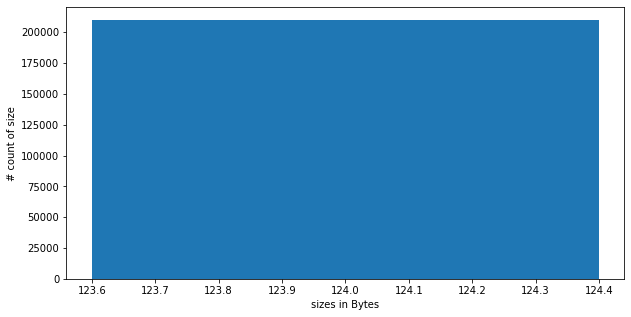

In [10]:
from turtle import position
import matplotlib.pyplot as plt

sizes = list(size_dict.keys())
counts = list(size_dict.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(sizes, counts)

plt.xlabel('sizes in Bytes')
plt.ylabel('# count of size')
plt.show()

In [11]:
sourceCode_np = df.sourceCode.values
codeClass_np = df.classLabel.values

In [12]:
from nltk.tokenize import word_tokenize
from collections import defaultdict

def split(str):
    return [char for char in str]

def tokenize(sourceCode):
    """Tokenize texts, build vocabulary and find maximum sentence length.
    
    Args:
        texts (List[str]): List of text data
    
    Returns:
        tokenized_texts (List[List[str]]): List of list of tokens
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    tokenized_codes = []
    ch2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    ch2idx['<pad>'] = 0

    # Building our vocab from the corpus starting from index 2
    idx = 1
    for code in sourceCode:
        tokenized_code = split(code)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_codes.append(tokenized_code)

        # Add new token to `word2idx`
        for token in tokenized_code:
            if token not in ch2idx:
                ch2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_code))

    return tokenized_codes, ch2idx, max_len

def encode(tokenized_codes, ch2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our CNN model.
    """

    input_ids = []
    for tokenized_code in tokenized_codes:
        # Pad sentences to max_len
        tokenized_code += ['<pad>'] * (max_len - len(tokenized_code))

        # Encode tokens to input_ids
        input_id = [ch2idx.get(token) for token in tokenized_code]
        input_ids.append(input_id)
    
    return np.array(input_ids)

In [13]:
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_sourceCodes, ch2idx, max_len = tokenize(sourceCode_np)
input_ids = encode(tokenized_sourceCodes, ch2idx, max_len)

Tokenizing...



In [14]:
def print_ch2idx(ch2idx):
    with open('../data/ch2idx.txt', 'a') as f:
        for key in ch2idx:
            f.write(key + '\t : ' + str(ch2idx[key]) + '\n')

In [15]:
print_ch2idx(ch2idx)

In [16]:
def tokenize_encode_class(classes):
    encoded_class = []
    class2idx = {}
    idx = 0

    for one_class in classes:

        if not one_class in class2idx:
            class2idx[one_class] = idx
            idx += 1
        
        encoded_class.append(class2idx[one_class])

    return np.array(encoded_class), class2idx, len(class2idx)


In [17]:
encoded_class2idx, class2idx, num_classes = tokenize_encode_class(codeClass_np)

In [18]:
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, encoded_class2idx, test_size = 0.2, random_state = 43
)

In [19]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)

def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Specify batch_size
    batch_size = 50

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, drop_last=True)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size, drop_last=True)

    return train_dataloader, val_dataloader

In [20]:
# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = \
data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[16, 32, 16],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.activation = nn.LogSoftmax(dim=-1)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.activation(self.fc(self.dropout(x_fc)))

        return logits

In [22]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=20,
                    filter_sizes=[16, 32, 16],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=num_classes,
                        dropout=0.5)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer



In [23]:
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/sourceCodeCNN{}'.format(timestamp))

In [24]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, title, val_dataloader=None, epochs=10):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        tot_train_loss = []

        # Put the model into the training mode
        model.train()
        train_accuracy = []
        for step, batch in enumerate(train_dataloader):
             # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            tot_train_loss.append(loss.item())

            # Get the predictions
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the accuracy rate
            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            train_accuracy.append(accuracy)

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = np.mean(tot_train_loss)
        train_accuracy = np.mean(train_accuracy)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

        writer.add_scalars(title + '-CNN Training vs. Testing Loss',
                { 'Train' : avg_train_loss, 'Test' : val_loss },
                epoch_i + 1)

        writer.add_scalars(title + '-CNN Training vs. Testing Accuracy',
                    { 'Train' : train_accuracy, 'Test' : val_accuracy },
                    epoch_i + 1)
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [25]:
# CNN-rand: Word vectors are randomly initialized.
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(ch2idx),
                                      embed_dim=100,
                                      filter_sizes=[8, 16, 32, 64],
                                      num_filters=[100, 200, 200, 100],
                                      learning_rate=0.25,
                                      num_classes=len(class2idx),
                                      dropout=0.5)
train(cnn_rand, optimizer, train_dataloader, '4LayerChngedKernel+soft+multLoss', val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


RuntimeError: The size of tensor a (50) must match the size of tensor b (21) at non-singleton dimension 1